In [24]:
%load_ext autoreload
%autoreload 2
import numpy as np
from pathlib import Path
from pasna_analysis import Embryo, Experiment, utils
import matplotlib.pyplot as plt

experiment_name = '20240515'
exp_path = Path.cwd().parent.joinpath('data',experiment_name)
exp = Experiment(exp_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


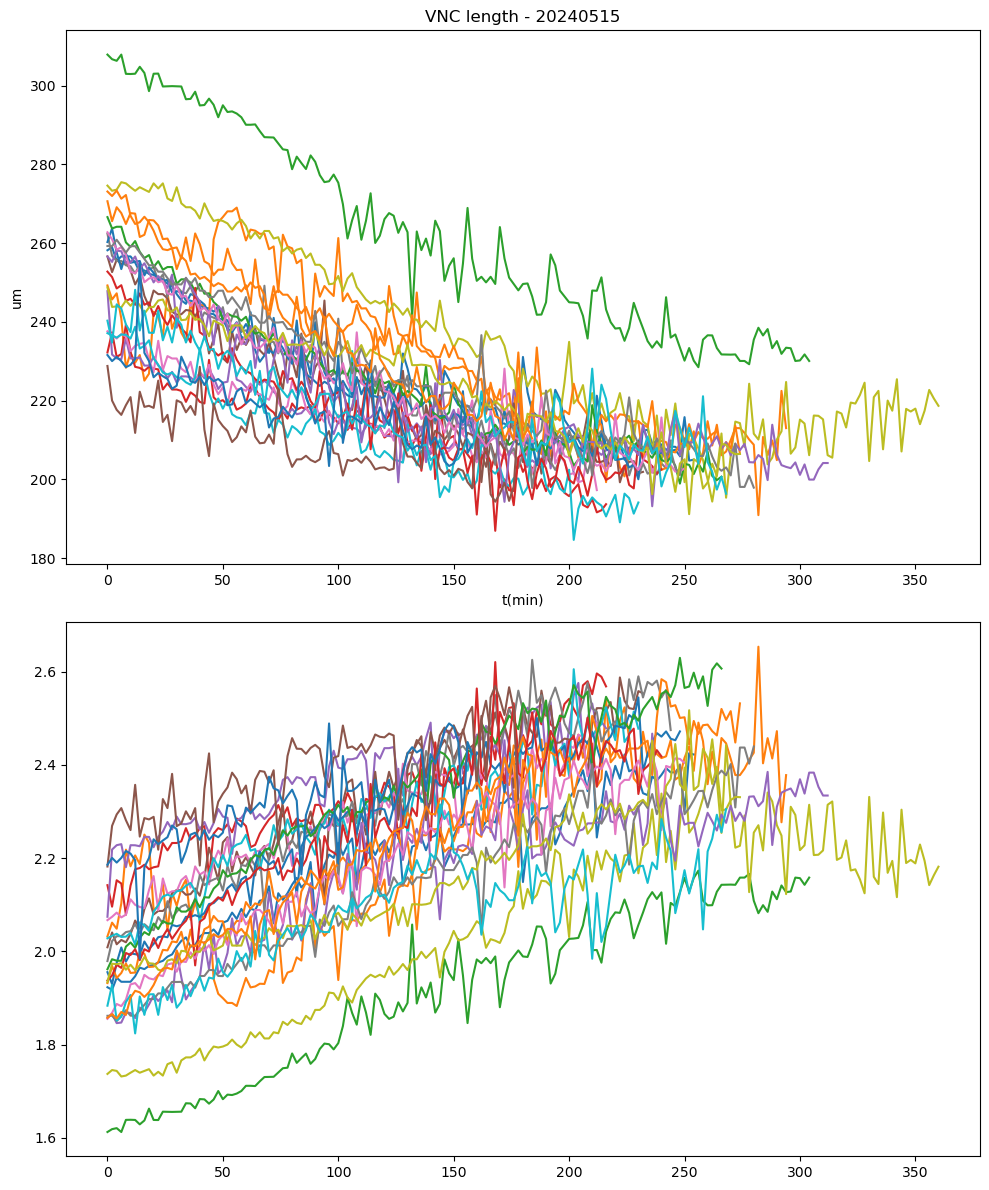

In [29]:
lengths = exp.lengths()
activities = exp.activity()

fig, ax = plt.subplots(2, figsize=(10, 12))

for l, a in zip(lengths, activities):
    emb = Embryo(a, l)
    Y = emb.vnc_length[:, 1]
    W = emb.developmental_time()
    X = emb.vnc_length[:, 0]/60

    ax[0].plot(X, Y)
    ax[1].plot(X, W)


ax[0].set_title(f'VNC length - {exp.name}')
ax[0].set_xlabel('t(min)')
ax[0].set_ylabel('um')

fig.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.0497782883199921


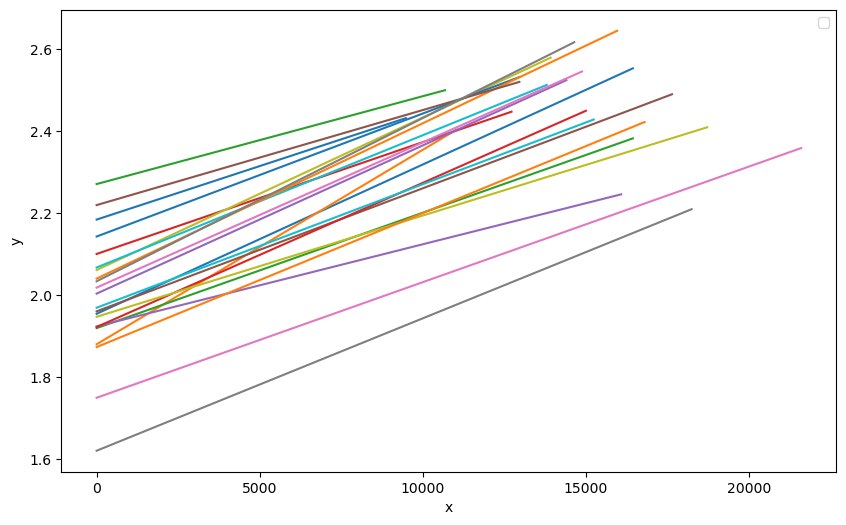

In [26]:
from scipy.optimize import curve_fit

def linear_func(x, a, b):
    return a*x + b

def log_func(x, a, b, c):
    return a*np.log(x + b) + c

def fit_data(x, y, func, p0=None):
    if p0:
        params_lin, _ = curve_fit(func, x, y, p0=p0, maxfev=1_000_000)
    else:
        params_lin, _ = curve_fit(func, x, y)
    y_fit = func(x, *params_lin)

    # Calculate R-squared for linear fit
    ss_res_lin = np.sum((y - y_fit) ** 2)
    ss_tot_lin = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res_lin / ss_tot_lin)

    return y_fit, r2

experiment = '20240515'
project_dir = Path.cwd().parent
experiment_dir = project_dir.joinpath('data', experiment)

lengths = list(experiment_dir.joinpath('lengths').iterdir())
activities = list(experiment_dir.joinpath('activity').iterdir())

i = 3

fig, ax = plt.subplots(figsize=(10,6))
r2s = []
rmses = []
for i, _ in enumerate(lengths): 
    emb_length = utils.get_initial_length_by_name(lengths[i].stem, experiment_dir/'full-length.csv')
    emb = Embryo(activities[i], lengths[i], emb_length)

    x = emb.vnc_length[:, 0].astype(np.float64)
    y = emb_length / emb.vnc_length[:, 1].astype(np.float64)

    linear = True
    if linear:
        y_fit, r2 = fit_data(x, y, linear_func)
    else:
        y_fit, r2 = fit_data(x, y, log_func, p0=[2,2,2])
    RMSE = np.sqrt(np.average((y-y_fit)**2))
    r2s.append(r2)
    rmses.append(RMSE)
    # Print the parameters and R-squared values
    # print(f"R-squared value for linear fit: {r2}")

# Plot the original data and the fitted curves
# plt.figure(figsize=(10, 6))
# plt.plot(x, y, label='Data')
# plt.plot(x, y_fit, color='blue', label='Log Fit')
    ax.plot(x, y_fit)
print(sum(rmses)/len(rmses))

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()